Todo : 
- implement UCB1
- check if there are other algorithms
- find good experiments to compare algorithms (Penser à des experiences ou le meilleur bras n'est pas evident à trouver/ passe au dessus qu'a la fin par ex)
- reproduce experiment of https://arxiv.org/pdf/1506.03271.pdf (Section 4)

3 algorithms : Exp3, Exp3.P, Exp3-IX

# Exp-3 algorithms

ref :  https://jeremykun.com/2013/11/08/adversarial-bandits-and-the-exp3-algorithm/

https://arxiv.org/pdf/1506.03271.pdf

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
# need to define class arm (cf TD2)
class Arm():
    """ 
    Defines an arm with arbitrary finite sequence of reward
    """
    def __init__(self, rewards_sequence):
        self.rewards = rewards_sequence
    
    def sample(self, t):
        return self.rewards[t]

In [8]:
class bernoulliArm():
    def __init__(self, mean):
        self.mean = mean
    
    def sample(self, t):
        return np.random.binomial(p=self.mean, n=1)

In [9]:
class evolvingBernoulliArm():
    def __init__(self, means, switching_time):
        self.means = means
        self.switching_time = switching_time
    
    def sample(self, t):
        if t <= self.switching_time:
            return np.random.binomial(p=self.means[0], n=1)
        else:
            return np.random.binomial(p=self.means[1], n=1)

In [10]:
def exp3(MAB, T, gamma=0.05, Exp3P=False, alpha=0):
    """
    Exp3 algorithm as in Auer et al. (2001)
    MAB: list of arms from Arm class
    T: time horizon
    gamma: exploration parameter for Exp3
    """
    
    K = len(MAB) # number of arms
    
    # initialize rewards estimation
    
    R = np.zeros(K)
    if Exp3P:
        bs = alpha * np.sqrt(T * K) * np.ones(K)
    
    # History of rewards
    reward_hist = []

    
    for t in range(T):
        # Set probabilities of drawing each arm
        if  not Exp3P:
            p = (1 - gamma) * np.exp(gamma * (R - np.min(R)) / K) /  np.sum(np.exp(gamma * (R - np.min(R)) / K)) + gamma / K
        else:
            p = (1-gamma) * np.exp(gamma / (3 * K) * ((R +bs) - np.min(R + bs))) / np.sum(np.exp(gamma / (3 * K) * ((R +bs) - np.min(R + bs)))) + gamma / K
        # Draw arm index
        drawn_index = np.random.choice(a=K, p=p) 
        # Draw corresponding reward
        drawn_reward = MAB[drawn_index].sample(t) 
        
        # Compute estimated reward
        estimated_reward = drawn_reward / p[drawn_index] 
        
        #update rewards estimation 
        R[drawn_index] += drawn_reward / p[drawn_index]
        
        if Exp3P:
            bs += alpha / (np.sqrt(K * T) * p)
        
        # Save obtained reward and weights
        reward_hist.append(drawn_reward) 
        
    return reward_hist, R

In [11]:
def exp3_Bianchi(MAB, T, eta):
    """
    Exp3 algorithm as in "Regret Analysis of Stochastic and 
    Nonstochastic Multi-armed Bandit Problems"
    by Bubeck and Bianchi
    
    MAB: list of arms from Arm class
    T: time horizon
    eta: list of length t of exploration parameters of Exp3
    """
    
    K = len(MAB) # number of arms
    
    # initialize rewards estimation   
    R = np.zeros(K)
    # History of rewards
    reward_hist = []
    
    for t in range(T):
        p = np.exp(eta[t] * (R - np.max(R)))
        p /= np.sum(p)
        
        # Draw arm index
        drawn_index = np.random.choice(a=K, p=p) 
        # Draw corresponding reward
        drawn_reward = MAB[drawn_index].sample(t) 
        
        # Compute estimated reward
        estimated_reward = drawn_reward / p[drawn_index] 
        
        #update rewards estimation 
        R[drawn_index] += drawn_reward / p[drawn_index]
        
        # Save obtained reward and weights
        reward_hist.append(drawn_reward)
        
    return reward_hist

def exp3P_Bianchi(MAB, T, eta, gamma, beta):
    """
    Exp3.P algorithm as in "Regret Analysis of Stochastic and 
    Nonstochastic Multi-armed Bandit Problems"
    by Bubeck and Bianchi
    
    MAB: list of arms from Arm class
    T: time horizon
    eta: parameter used in the exponential
    gamma: random exploration probability
    beta: added bias
    """
    
    K = len(MAB) # number of arms
    
    # initialize rewards estimation   
    R = np.zeros(K)
    # History of rewards
    reward_hist = []
    
    for t in range(T):
        p = np.exp(eta * (R - np.max(R)))
        p /= np.sum(p)
        p = (1 - gamma) * p + gamma / K
        
        # Draw arm index
        drawn_index = np.random.choice(a=K, p=p) 
        # Draw corresponding reward
        drawn_reward = MAB[drawn_index].sample(t) 
        
        # Compute estimated reward
        estimated_reward = (drawn_reward + beta) / p[drawn_index] 
        
        #update rewards estimation 
        R[drawn_index] += drawn_reward / p[drawn_index]
        
        # Save obtained reward and weights
        reward_hist.append(drawn_reward)
        
    return reward_hist

In [12]:
def exp3_IX(MAB, T, eta, gamma):
    """
    Exp3-IX algorithm as in Explore no more (Neu)
    MAB: list of arms from Arm class
    T: the time horizon
    eta: learning rate
    gamma: implicit exploration parameter
    """
    
    K = len(MAB) # number of arms
    W = np.ones(K) # initialize weights
    
    # History of rewards and weights
    reward_hist = []
    
    R = np.zeros(K) #estimated rewards
    
    for t in range(T):
        
        # Set probabilities of drawing each arm

        p = np.exp(eta * (R - np.max(R))) / np.sum(np.exp(eta * (R - np.max(R))))

        # Draw arm index
        drawn_index = np.random.choice(a=K, p=p)
        
        # Draw corresponding reward
        drawn_reward = MAB[drawn_index].sample(t) 
        
        # Compute estimated reward with implicit exploration
        estimated_reward = drawn_reward/(p[drawn_index] + gamma) 
        
        R[drawn_index] += estimated_reward #update rewards estimation
        
        # Save obtained reward and weights
        reward_hist.append(drawn_reward) 
        
    return reward_hist, R

In [13]:
def UCB1(MAB, T, rho):
    n_iter = 0
    K = len(MAB)
    means_empirical = np.array([0. for i in range(K)])
    number_arms_draw = np.array([1 for i in range(K)])
    rew_draws = [[], []]

    # initialisation phases
    while n_iter < min(K, T):
        reward = MAB[n_iter].sample(n_iter)
        rew_draws[0].append(reward)
        rew_draws[1].append(n_iter)
        means_empirical[n_iter] += reward
        n_iter += 1
    # UCB
    while n_iter < T:
        i = np.argmax(means_empirical + rho *
                      (np.log(n_iter + 1) / (2 * number_arms_draw))**2)
        # drawing
        reward = MAB[i].sample(n_iter)
        rew_draws[0].append(reward)
        rew_draws[1].append(i)
        # update statistics
        number_arms_draw[i] += 1
        means_empirical[i] += ((reward - means_empirical[i]) / (number_arms_draw[i]))
        # increment
        n_iter += 1
    return rew_draws

In [14]:
def Random(MAB, T):
    
    reward_hist = []
    for i in range(T):
        index = np.random.randint(len(MAB))
        reward = MAB[index].sample(i)
        
        reward_hist.append(reward)
    return reward_hist

In [15]:
# we define gaussian trajectories normalized to lie in [0, 1]

def gaussian_traj(T):
    gp = np.cumsum(np.random.normal(0, 2, T))

    # normalization (to have rewards in [0, 1]) :
    gp += np.abs(min(gp))
    gp /= max(gp)
    return(gp)

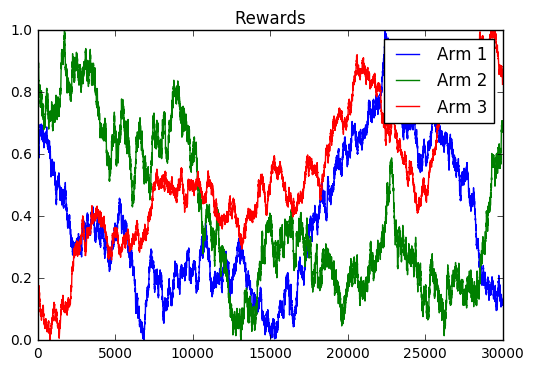

In [27]:
T = 30000

arm1 = Arm(gaussian_traj(T))
arm2 = Arm(gaussian_traj(T))
arm3 = Arm(gaussian_traj(T))

MAB = [arm1, arm2, arm3]

plt.plot(arm1.rewards)
plt.plot(arm2.rewards)
plt.plot(arm3.rewards)
plt.legend(['Arm 1', 'Arm 2', 'Arm 3'])
plt.title('Rewards')

### Calculate best arm at round t

In [22]:
arm1_cumsum = np.cumsum(arm1.rewards)
arm2_cumsum = np.cumsum(arm2.rewards)
arm3_cumsum = np.cumsum(arm3.rewards)

best_action_rew = np.zeros(T)

for t in range(T):
    best_action_rew[t] = max(arm1_cumsum[t], arm2_cumsum[t], arm3_cumsum[t])

## Weak regret bound of Exp3 if the number of rounds is known

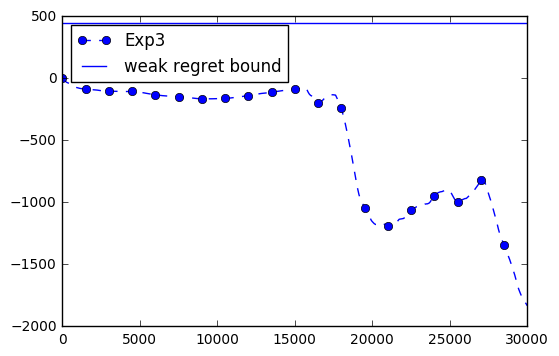

In [23]:
K = len(MAB)
eta = np.sqrt(2 * np.log(K) / T * K)
etas = [eta for _ in range(T)]

rew_exp3 = np.zeros(T)
n_iter = 20

for i in range(n_iter):
    rew_exp3 += exp3_Bianchi(MAB, T, etas)
    
rew_exp3 /= n_iter
    
exp3_cumsum = np.cumsum(rew_exp3)
plt.plot(exp3_cumsum - best_action_rew, '--o', markevery=1500, label="Exp3")

plt.axhline(np.sqrt( 2 * T * K * np.log(K)), label="weak regret bound")
plt.legend(loc="upper left")

## Weak regret of Exp3 when the number of rounds is uknown

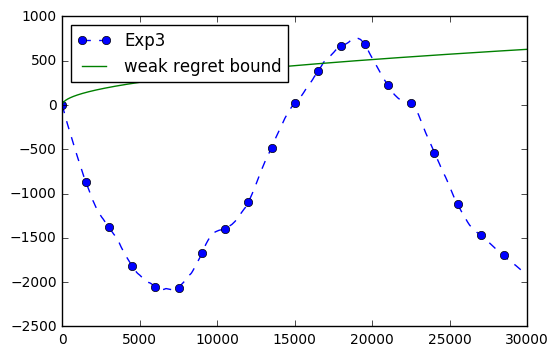

In [30]:
K = len(MAB)
etas = [np.sqrt(2 * np.log(K) / (t + 1) * K) for t in range(T)]

rew_exp3 = np.zeros(T)
n_iter = 1000

for i in range(n_iter):
    rew_exp3 += exp3_Bianchi(MAB, T, etas)
rew_exp3 /= n_iter

    
exp3_cumsum = np.cumsum(rew_exp3)
plt.plot(exp3_cumsum - best_action_rew, '--o', markevery=1500, label="Exp3")

plt.plot([np.sqrt(4 * t * K * np.log(K)) for t in range(T)], label="weak regret bound")
plt.legend(loc="upper left")

## Regret of Exp3.P

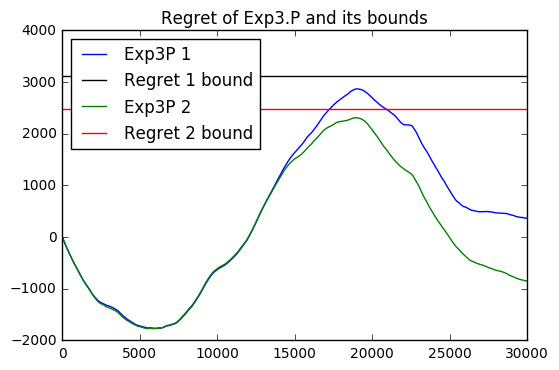

In [34]:
K = len(MAB)
delta = 0.05
eta = 0.95 * np.sqrt(np.log(K) / (T * K))
gamma = 1.05 * np.sqrt(np.log(K) * K / T)
beta = np.sqrt(np.log(K / delta) /  (T * K))

#calculate best arm at each round
best_action_rew = np.zeros(T)
for t in range(T):
    best_action_rew[t] = max(arm1_cumsum[t], arm2_cumsum[t], arm3_cumsum[t])

#first type of regret bound
rew_exp3P = exp3P_Bianchi(MAB, T, eta, gamma, beta)

exp3P_cumsum = np.cumsum(rew_exp3P)

plt.plot(exp3P_cumsum - best_action_rew, label="Exp3P 1") 
plt.axhline(5.15 * np.sqrt(T * K * np.log(K / delta)), c="black", label="Regret 1 bound")

#second type of regret bound
beta = np.sqrt(np.log(K) /  (T * K))

rew_exp3P = exp3P_Bianchi(MAB, T, eta, gamma, beta)
exp3P_cumsum = np.cumsum(rew_exp3P)
plt.plot(exp3P_cumsum - best_action_rew, label="Exp3P 2") 
plt.axhline(5.15 * np.sqrt(T * K * np.log(K)) + np.sqrt(T * K / np.log(K)) * np.log(1 / delta), c="red", label="Regret 2 bound")

plt.legend(loc="upper left")
plt.title("Regret of Exp3.P and its bounds")

## Weak regret of Exp3.P

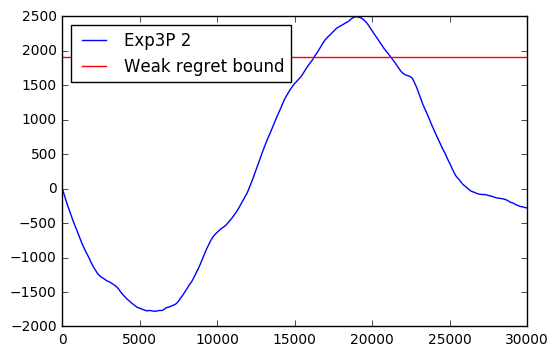

In [49]:
#hyperparameters
eta = 0.95 * np.sqrt(np.log(K) / (T * K))
gamma = 1.05 * np.sqrt(np.log(K) * K / T)
beta = np.sqrt(np.log(K) /  (T * K))

#calculate best arm at each round
best_action_rew = np.zeros(T)
for t in range(T):
    best_action_rew[t] = max(arm1_cumsum[t], arm2_cumsum[t], arm3_cumsum[t])

rew_exp3P = np.zeros(T)
n_iter = 100
for i in range(n_iter):
    rew_exp3P += exp3P_Bianchi(MAB, T, eta, gamma, beta)
rew_exp3P /= n_iter

exp3P_cumsum = np.cumsum(rew_exp3P)

plt.plot(exp3P_cumsum - best_action_rew, label="Exp3P 2") 
plt.axhline(5.15 * np.sqrt(T * K * np.log(K)) + np.sqrt(T * K / np.log(K)), c="red", label="Weak regret bound")

plt.legend(loc="upper left")

### Compairison of different algorithms on gaussian arms

In [30]:
#set up the parameters

K = len(MAB)
eta = np.sqrt(2 * np.log(K) / T * K)
etas_exp3 = [eta for _ in range(T)]

delta = 0.05
eta = 0.95 * np.sqrt(np.log(K) / (T * K))
gamma = 1.05 * np.sqrt(np.log(K) * K / T)
beta = np.sqrt(np.log(K / delta) /  (T * K))

In [36]:
rew = exp3_Bianchi(MAB, T, eta=etas)
rew_P = exp3P_Bianchi(MAB, T, beta=beta, gamma=gamma, eta=eta)
rew_IX, _ = exp3_IX(MAB, T, eta=eta, gamma=0.5)
rew_UCB, _ = UCB1(MAB, T, rho=0.2)
rew_random = Random(MAB, T)

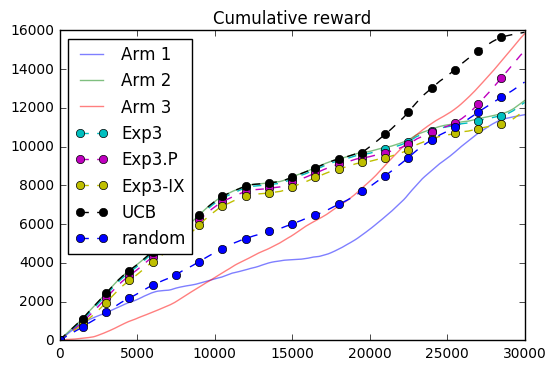

In [37]:
arm1_cumsum = np.cumsum(arm1.rewards)
arm2_cumsum = np.cumsum(arm2.rewards)
arm3_cumsum = np.cumsum(arm3.rewards)
exp3_cumsum = np.cumsum(rew)
exp3_P_cumsum = np.cumsum(rew_P)
exp3_IX_cumsum = np.cumsum(rew_IX)
UCB_cumsum = np.cumsum(rew_UCB)
rew_cumsum = np.cumsum(rew_random)

plt.plot(arm1_cumsum, alpha=0.5, label="Arm 1")
plt.plot(arm2_cumsum, alpha=0.5, label="Arm 2")
plt.plot(arm3_cumsum, alpha=0.5, label="Arm 3")

plt.plot(exp3_cumsum, '--o', markevery=1500, label="Exp3")

plt.plot(exp3_P_cumsum, '--o', markevery=1500, label="Exp3.P")
plt.plot(exp3_IX_cumsum, '--o', markevery=1500, label="Exp3-IX")
plt.plot(UCB_cumsum, '--o', markevery=1500, label="UCB")
plt.plot(rew_cumsum, '--o', markevery=1500, label="random")

plt.legend(loc="upper left")
plt.title("Cumulative reward")

### Adversaire vicieux

At eqch

In [73]:
T = 100000

nb_arms = 10

Rewards = [[0 for _ in range(T)] for _ in range(nb_arms)]
for i in range(T):
    Rewards[i % nb_arms][i] = 1
MAB = [Arm(rewards_sequence=Rewards[i]) for i in range(nb_arms)]

In [75]:
K = len(MAB)
base_parameter = np.sqrt(np.log(K) / (T * K))

In [97]:
T = 10000
T2 = 5000

n_iter = 50
nb_multipliers = 10
R_T = np.zeros((3, nb_multipliers, n_iter))
R_T2 = np.zeros((3, nb_multipliers, n_iter))

for j, multiplier in enumerate(np.linspace(1e-3, 5e1, nb_multipliers)):
    print(multiplier)
    for i in range(50):
        eta = multiplier * base_parameter
        rew = exp3_Bianchi(MAB, T, eta=[eta for _ in range(T)])

        rew_P = exp3P_Bianchi(MAB, T, beta=eta, gamma=K * eta, eta=eta)
        rew_IX, _ = exp3_IX(MAB, T, eta, eta / 2)

        exp3_T2, exp3_P_T2, exp3_IX_T2 = np.sum(
            rew[: T2]), np.sum(rew_P[: T2]), np.sum(rew_IX[: T2])

        exp3_T, exp3_P_T, exp3_IX_T = exp3_T2 + np.sum(rew[T2:]), exp3_P_T2 + np.sum(rew_P[T2:]
                                                                                     ), exp3_IX_T2 + np.sum(rew_IX[T2:])

        R_T2[:, j, i] = [exp3_T2, exp3_P_T2, exp3_IX_T2]
        R_T[:, j, i] = [exp3_T, exp3_P_T, exp3_IX_T]

0.001
5.55644444444
11.1118888889
16.6673333333
22.2227777778
27.7782222222
33.3336666667
38.8891111111
44.4445555556
50.0


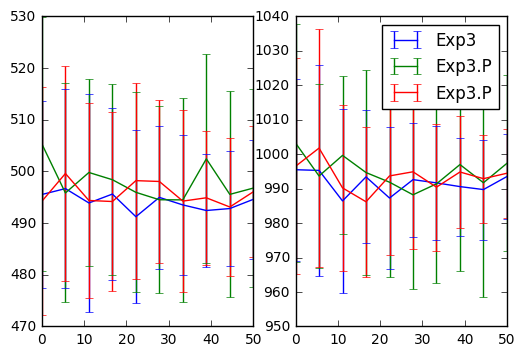

In [104]:
R_T_mean = np.mean(R_T, axis=2)
R_T2_mean = np.mean(R_T2, axis=2)
R_T_std = np.std(R_T, axis=2)
R_T2_std = np.std(R_T2, axis=2)

plt.subplot(1,2,1)
plt.errorbar(np.linspace(0, 50, 10), R_T2_mean[0], R_T2_std[0], label="Exp3")
plt.errorbar(np.linspace(0, 50, 10), R_T2_mean[1], R_T2_std[1], label="Exp3.P")
plt.errorbar(np.linspace(0, 50, 10), R_T2_mean[2], R_T2_std[2], label="Exp3.P")

plt.subplot(1,2,2)
plt.errorbar(np.linspace(0, 50, 10), R_T_mean[0], R_T_std[0], label="Exp3")
plt.errorbar(np.linspace(0, 50, 10), R_T_mean[1], R_T_std[1], label="Exp3.P")
plt.errorbar(np.linspace(0, 50, 10), R_T_mean[2], R_T_std[2], label="Exp3.P")
plt.legend()

In [67]:
rew = exp3_Bianchi(MAB, T, eta=etas)
rew_P = exp3P_Bianchi(MAB, T, beta=beta, gamma=gamma, eta=eta)
rew_IX, _ = exp3_IX(MAB, T, eta=eta, gamma=0.5)
rew_UCB, _ = UCB1(MAB, T, rho=0.7)
rew_random = Random(MAB, T)

In [74]:
#set up the parameters

K = len(MAB)
eta = np.sqrt(2 * np.log(K) / T * K)
etas_exp3 = [eta for _ in range(T)]

delta = 0.05
eta = 0.95 * np.sqrt(np.log(K) / (T * K))
gamma = 1.05 * np.sqrt(np.log(K) * K / T)
beta = np.sqrt(np.log(K / delta) /  (T * K))

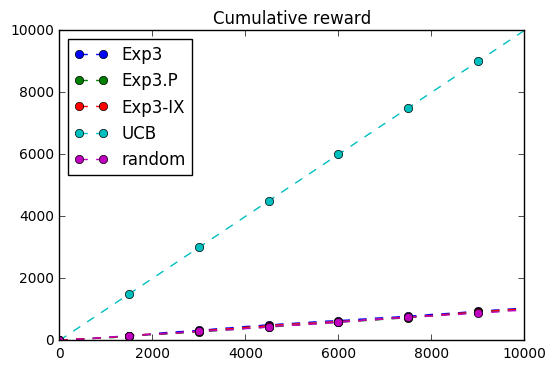

In [68]:
exp3_cumsum = np.cumsum(rew)
exp3_P_cumsum = np.cumsum(rew_P)
exp3_IX_cumsum = np.cumsum(rew_IX)
UCB_cumsum = np.cumsum(rew_UCB)
rew_cumsum = np.cumsum(rew_random)

plt.plot(exp3_cumsum, '--o', markevery=1500, label="Exp3")

plt.plot(exp3_P_cumsum, '--o', markevery=1500, label="Exp3.P")
plt.plot(exp3_IX_cumsum, '--o', markevery=1500, label="Exp3-IX")
plt.plot(UCB_cumsum, '--o', markevery=1500, label="UCB")
plt.plot(rew_cumsum, '--o', markevery=1500, label="random")

plt.legend(loc="upper left")
plt.title("Cumulative reward")

# Exp3-IX expriment

Ref : https://arxiv.org/pdf/1506.03271.pdf (Section 4)

10-arm bandit problem where
all losses are independent draws of Bernoulli random variables. 

The mean rewards of arms 1 through 8 are 0.5

The mean reward of arm 9 is $0.5 + \delta$ for all rounds $t = 1, 2, . . . , T$. 

The mean rewards of
arm 10 are changing over time: for rounds $t \leq \frac{T}{2}$, the mean is $0.5 - \delta$, and $0.5 + 4\delta$ afterwards.

/!\ We consider rewards instead of losses (opposite to the article) 

$\beta = \frac{\gamma}{K} = \frac{\eta}{20}$ ou $\beta = \eta$ ???

In [ ]:
T = 1e6
K = 10
delta = 0.1
MAB_IX = [bernoulliArm(0.5) for i in range(8)]
MAB_IX.append(bernoulliArm(0.5 + delta))
MAB_IX.append(evolvingBernoulliArm([0.5 - delta, 0.5 + 4*delta], T/2))

In [26]:
base_eta = np.sqrt(np.log(K) / T * K)
print(eta)

0.00181544398592


In [19]:
R_T = []
R_T2 = []

T = 10000
T2 = 5000
for multiplier in np.linspace(1e-2, 1e2, 50):
    print(multiplier)
    R_T2_mean = np.zeros(3)
    R_T_mean = np.zeros(3)
    for i in range(5):
        rew, _ = exp3_Bianchi(MAB_IX, T, eta=)

        rew_P, weights = exp3(MAB_IX, T, Exp3P=True, gamma=eta)
        rew_IX, _ = exp3_IX(MAB_IX, T, eta, eta/2)

        exp3_T2, exp3_P_T2, exp3_IX_T2 = np.sum(rew[: T2]), np.sum(rew_P[: T2]), np.sum(rew_IX[: T2])

        exp3_T, exp3_P_T, exp3_IX_T = exp3_T2 + np.sum(rew[T2:]), exp3_P_T2 + np.sum(rew_P[T2 :]), exp3_IX_T2 + np.sum(rew_IX[T2:])

        
        R_T2_mean += [exp3_T2, exp3_P_T2, exp3_IX_T2]
        R_T_mean += [exp3_T, exp3_P_T, exp3_IX_T]
    R_T2.append(R_T2_mean) 
    R_T.append(R_T_mean)
rew_UCB, _ = UCB1(MAB, T, rho=0.2)
UCB_cumsum = np.cumsum(rew_UCB)
R_T2 /= 50
R_T /= 50

1e-07
0.0204082612245
0.040816422449
0.0612245836735
0.081632744898
0.102040906122
0.122449067347
0.142857228571
0.163265389796
0.18367355102
0.204081712245
0.224489873469
0.244898034694
0.265306195918
0.285714357143
0.306122518367
0.326530679592
0.346938840816
0.367347002041
0.387755163265
0.40816332449
0.428571485714
0.448979646939
0.469387808163
0.489795969388
0.510204130612
0.530612291837
0.551020453061
0.571428614286
0.59183677551
0.612244936735
0.632653097959
0.653061259184
0.673469420408
0.693877581633
0.714285742857
0.734693904082
0.755102065306
0.775510226531
0.795918387755
0.81632654898
0.836734710204
0.857142871429
0.877551032653
0.897959193878
0.918367355102
0.938775516327
0.959183677551
0.979591838776
1.0


TypeError: unsupported operand type(s) for /=: 'list' and 'int'

In [20]:
plt.plot(RT, label="T")
plt.plot(RT2, label="T2")
plt.legend()

NameError: name 'RT' is not defined

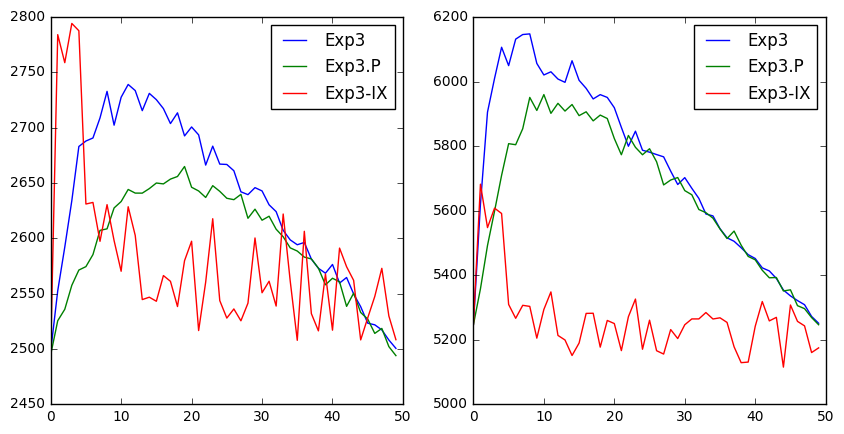

In [24]:
RT2 = np.array(R_T2)
RT = np.array(R_T)
RT /= 50
RT2 /= 50
plt.subplots(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(RT2[:, 0], label="Exp3")
plt.plot(RT2[:, 1], label="Exp3.P")
plt.plot(RT2[:, 2], label="Exp3-IX")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(RT[:, 0], label="Exp3")
plt.plot(RT[:, 1], label="Exp3.P")
plt.plot(RT[:, 2], label="Exp3-IX")
plt.legend()

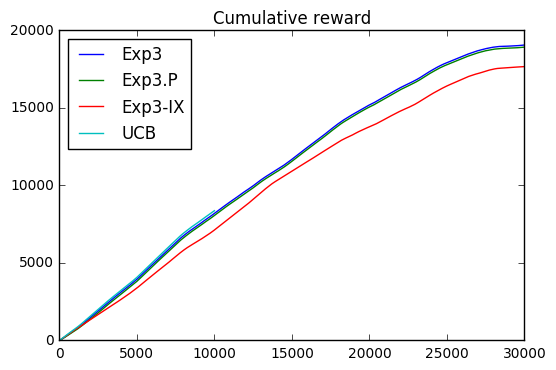

In [33]:

plt.plot(exp3_cumsum)
plt.plot(exp3_P_cumsum)
plt.plot(exp3_IX_cumsum)
plt.plot(UCB_cumsum)
plt.legend(['Exp3', 'Exp3.P', 'Exp3-IX', "UCB"], loc="upper left")
plt.title("Cumulative reward")